In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
import duckdb
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv('bank.csv')

# Connect to an in-memory DuckDB instance
con = duckdb.connect(database=':memory:')

# Register the DataFrame as a table for SQL queries
con.register('bank_raw', df)


In [90]:
duplicates = df[df.duplicated()]
print(duplicates)
print("Number of duplicated rows:", df.duplicated().sum())


Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, deposit]
Index: []
Number of duplicated rows: 0


In [87]:
# df
# df.duplicated().sum()
dup_columns = ['age', 'job', 'balance']
dup_rows = df[df.duplicated(subset=dup_columns)]
print(dup_rows)



       age          job  marital  education default  balance housing loan  \
127     30  blue-collar   single  secondary      no      239     yes   no   
164     35  blue-collar  married  secondary      no        0     yes  yes   
459     30  blue-collar   single    primary      no        0      no   no   
534     38   technician  married  secondary      no        0     yes   no   
620     36     services  married  secondary      no        0      no   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
11144   60      retired  married  secondary      no        0     yes   no   
11147   44   unemployed  married  secondary      no        0      no   no   
11148   32  blue-collar  married  secondary      no        1     yes   no   
11160   43   technician  married  secondary      no        0      no  yes   
11161   34   technician  married  secondary      no        0      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \

In [81]:
# Create CUSTOMER table with a generated customer_id
con.execute("""
CREATE TABLE customer AS
SELECT
    row_number() OVER () AS customer_id,
    age,
    job,
    marital,
    education,
    "default" AS defaults,
    balance,
    housing,
    loan,

 CASE
        WHEN age BETWEEN 0 AND 33 THEN 'young'
        WHEN age BETWEEN 34 AND 66 THEN 'middle-aged'
        ELSE 'senior'
    END AS age_group

FROM bank_raw""")


# Create CAMPAIGN table using the same generated customer_id order
con.execute("""
    CREATE TABLE campaign AS
    SELECT
        row_number() OVER () AS customer_id,
        contact,
        day,
        month,
        duration,
        campaign,
        pdays,
        previous,
        poutcome,
        deposit
    FROM bank_raw;
""")


In [80]:
# con.execute("""DROP TABLE IF EXISTS customer""")
# con.execute("""DROP TABLE IF EXISTS campaign""")


In [22]:
# con.execute("""
# CREATE TABLE customer AS
# SELECT
#     row_number() OVER () AS customer_id,
#     age,
#     job,
#     marital,
#     education,
#     "default" AS defaults,
#     balance,
#     housing,
#     loan,

#  CASE
#         WHEN age BETWEEN 0 AND 33 THEN 'young'
#         WHEN age BETWEEN 34 AND 66 THEN 'middle-aged'
#         ELSE 'senior'
#     END AS age_group

# FROM bank_raw""")


In [82]:
con.execute("""ALTER TABLE customer ADD COLUMN has_loan_or_housing INTEGER""")


In [83]:
con.execute("""UPDATE customer
SET has_loan_or_housing = CASE
WHEN loan = 'yes' OR housing = 'yes' THEN 1
ELSE 0
END
""")


In [85]:
customer_df = con.execute("""
    SELECT *
    FROM customer
""").fetchdf()
customer_df.head(12)

,customer_id,age,job,marital,education,defaults,balance,housing,loan,age_group,has_loan_or_housing
0,1,59,admin.,married,secondary,no,2343,yes,no,middle-aged,1
1,2,56,admin.,married,secondary,no,45,no,no,middle-aged,0
2,3,41,technician,married,secondary,no,1270,yes,no,middle-aged,1
3,4,55,services,married,secondary,no,2476,yes,no,middle-aged,1
4,5,54,admin.,married,tertiary,no,184,no,no,middle-aged,0
5,6,42,management,single,tertiary,no,0,yes,yes,middle-aged,1
6,7,56,management,married,tertiary,no,830,yes,yes,middle-aged,1
7,8,60,retired,divorced,secondary,no,545,yes,no,middle-aged,1
8,9,37,technician,married,secondary,no,1,yes,no,middle-aged,1
9,10,28,services,single,secondary,no,5090,yes,no,young,1


In [ ]:
duplicates = df[df.duplicated()]
print(duplicates)
print("Number of duplicated rows:", df.duplicated().sum())

In [86]:
campaign_df = con.execute("""
    SELECT *
    FROM campaign
""").fetchdf()
campaign_df.head(12)

,customer_id,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1,unknown,5,may,1042,1,-1,0,unknown,yes
1,2,unknown,5,may,1467,1,-1,0,unknown,yes
2,3,unknown,5,may,1389,1,-1,0,unknown,yes
3,4,unknown,5,may,579,1,-1,0,unknown,yes
4,5,unknown,5,may,673,2,-1,0,unknown,yes
5,6,unknown,5,may,562,2,-1,0,unknown,yes
6,7,unknown,6,may,1201,1,-1,0,unknown,yes
7,8,unknown,6,may,1030,1,-1,0,unknown,yes
8,9,unknown,6,may,608,1,-1,0,unknown,yes
9,10,unknown,6,may,1297,3,-1,0,unknown,yes


In [60]:
con.execute("COPY customer TO 'customer.parquet' (FORMAT PARQUET)")
con.execute("COPY campaign TO 'campaign.parquet' (FORMAT PARQUET)")

In [63]:
customer_df['age'].min()    # Minimum age
#customer_df['age'].max()    # Maximum age


18

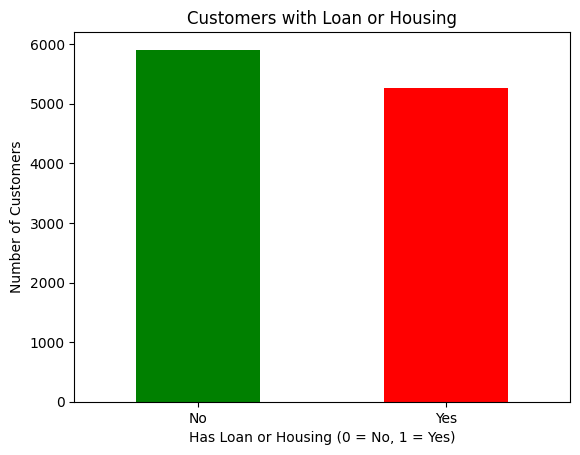

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
customer_df['has_loan_or_housing'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Customers with Loan or Housing')
plt.xlabel('Has Loan or Housing (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()


In [59]:
# # Merge customer and campaign data to get deposit info
# merged_df2 = customer_df.merge(campaign_df, on='customer_id')

# # Group by 'has_loan_or_housing' and 'deposit'
# loan_deposit_group = merged_df2.groupby(['has_loan_or_housing', 'deposit']).size().unstack()
# #
# # Plot
# loan_deposit_group.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'])

# plt.title('Deposit Outcome vs Loan or Housing Status')
# plt.xlabel('Has Loan or Housing (0 = No, 1 = Yes)')
# plt.ylabel('Number of Customers')
# plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
# plt.legend(title='Deposit')
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


In [48]:
# Merge customer table and campaign table
result_df = customer_df.merge(campaign_df, on='customer_id')


In [49]:
# Convert deposit to binary (1='yes' and 0 ='no')
result_df['deposit'] = result_df['deposit'].map({'yes': 1, 'no': 0})



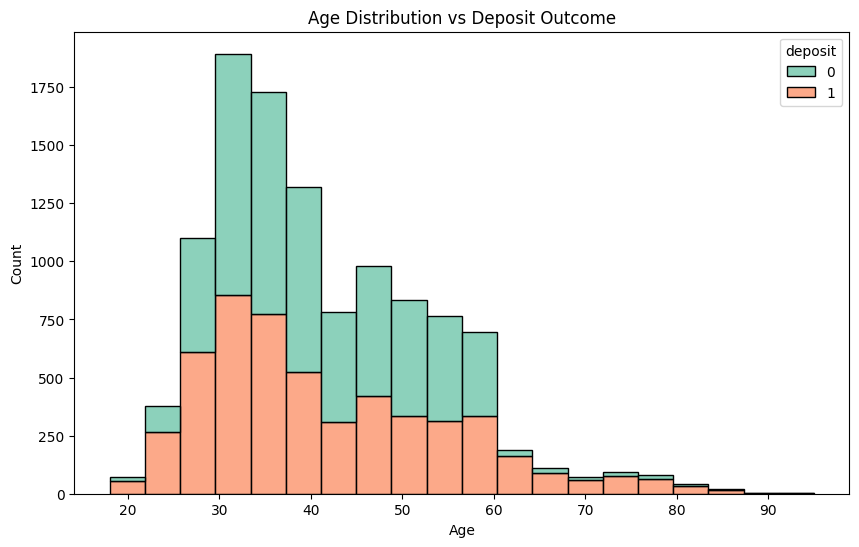

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='age', hue='deposit', multiple='stack', palette='Set2', bins=20)

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution vs Deposit Outcome")
plt.show()

In [53]:
result_df2 = campaign_df[['duration', 'deposit']].copy()


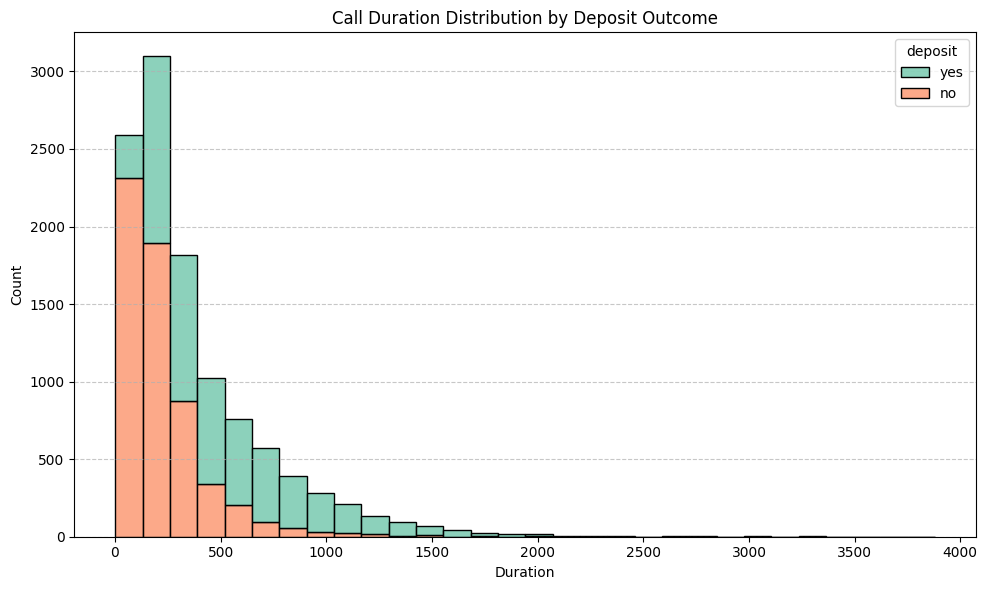

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df2, x='duration', hue='deposit', multiple='stack', bins=30, palette="Set2")

plt.title("Call Duration Distribution by Deposit Outcome")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
# job vs deposit
job_group = customer_df.merge(campaign_df, on='customer_id')


In [56]:
job_group = job_group.groupby(['job', 'deposit']).size().reset_index(name='count')


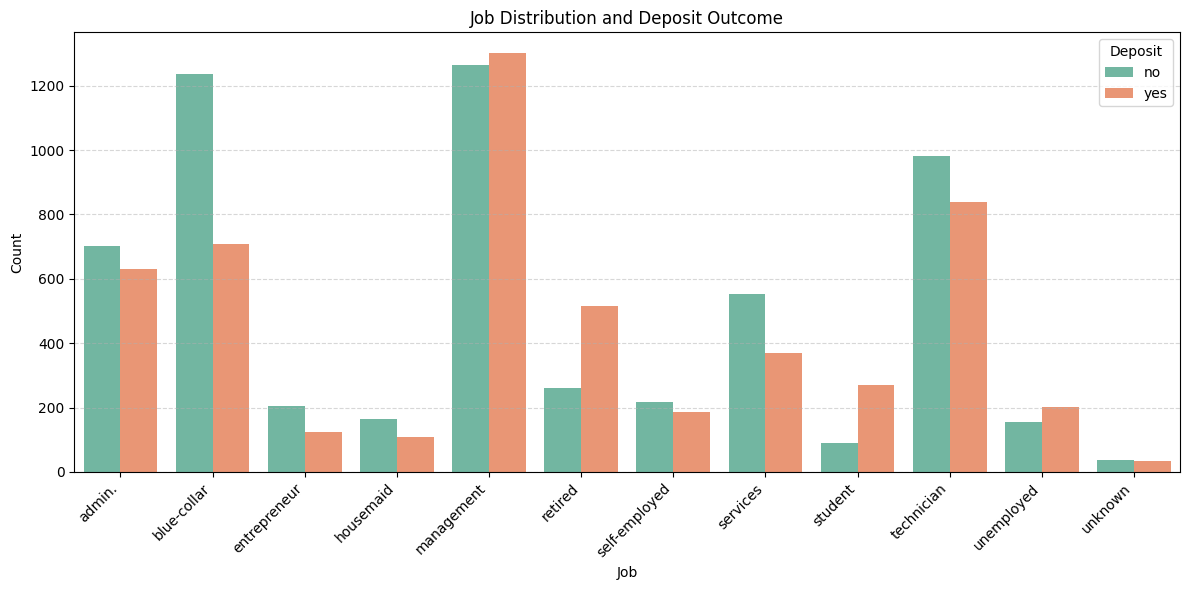

In [57]:

plt.figure(figsize=(12, 6))
sns.barplot(data=job_group, x='job', y='count', hue='deposit', palette='Set2')

plt.xticks(rotation=45, ha='right')
plt.title("Job Distribution and Deposit Outcome")
plt.xlabel("Job")
plt.ylabel("Count")
plt.legend(title='Deposit')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()